# Introduction

Sometimes you want to travel or move to some city in Europe but you do not really know where to go. This project studies the demographic and some economic data from all European countries in order to find the best countries to live. Then we have choosen one city of each given country where we are making a weather study and obtain the main interest places nearby to visit.

We have obtained a data set of the accomodations in each city and plotted some information in order to determinate which city has the best quality-price ratio for travelling to.

# Initalization

Start importing the needed libraries for this project. We import libraries for working with datasets like `pandas` and `numpy` for operating with numerical data, libraries for working with files like `os`, `pathlib` and `pickle`. And libraries for making use of APIs like `requests` and for webscrapping like `selenium`.

For representing the results we will be using `matplotlib`, `seaborn` and `plotly`.

In [2]:
import pandas as pd
import requests
import pickle as pkl
import numpy as np
import folium
import pprint
import os

from dotenv import load_dotenv
from pathlib import Path
from folium import plugins
from selenium import webdriver
from selenium.webdriver.common.by import By

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from time import sleep

In [3]:
DATA_DIR = Path("..") / "data"
FIG_DIR = Path("..") / "figures"

# Load the .env file
load_dotenv()

True

## Loading the data from Eurostat

From the Eurostat website: https://ec.europa.eu/eurostat/web/main/data/database we are obtaining data about general people satisfaction and GPD data of each country using the Eurostat API.

In [4]:
# Extracting data from Eurostat to choose the countries we are studying

# Satisfaction data
eurostat_satisfaction_query = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/ilc_pw01?lang=en&isced11=TOTAL&indic_wb=LIFESAT&sex=T&age=Y_GE16&geo=EA20&geo=BE&geo=BG&geo=CZ&geo=DK&geo=DE&geo=EE&geo=IE&geo=EL&geo=ES&geo=FR&geo=HR&geo=IT&geo=CY&geo=LV&geo=LT&geo=LU&geo=HU&geo=MT&geo=NL&geo=AT&geo=PL&geo=PT&geo=RO&geo=SI&geo=SK&geo=FI&geo=SE&geo=IS&geo=NO&geo=CH&geo=UK&geo=ME&geo=MK&geo=AL&geo=RS&geo=TR&geo=XK&time=2022"
satisfaction_response = requests.get(eurostat_satisfaction_query)
satisfaction_json = satisfaction_response.json()

# GDP data
eurostat_gpd_query = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/tipsau10?lang=en&unit=CP_MNAC&geo=EA20&geo=BE&geo=BG&geo=CZ&geo=DK&geo=DE&geo=EE&geo=IE&geo=EL&geo=ES&geo=FR&geo=HR&geo=IT&geo=CY&geo=LV&geo=LT&geo=LU&geo=HU&geo=MT&geo=NL&geo=AT&geo=PL&geo=PT&geo=RO&geo=SI&geo=SK&geo=FI&geo=SE&time=2022"
gpd_response = requests.get(eurostat_gpd_query)
gpd_json = gpd_response.json()

Once we have obtained the JSON files from the API, satisfaction ang GPD values must be extracted.

In [5]:
# Extracting the data from the json
countries_id = satisfaction_json["dimension"]["geo"]["category"]["index"]
satisfaction_values = satisfaction_json["value"]
countries_full_name = satisfaction_json["dimension"]["geo"]["category"]["label"]

gpd_values = gpd_json["value"]

Finally, in the next two code cells, the values are saved in one final dictionary in order to build a dataframe.

In [6]:
# Creating a dictionary relating the country names to the country satisfaction values

satisfaction_values_dict = {}
satisfaction_per_country_code = {}
final_satisf_dict = {}

for id in countries_id.values():
    satisfaction_values_dict[id] = satisfaction_values.get(str(id))

for i, j in zip(countries_id, satisfaction_values_dict):
    satisfaction_per_country_code[i] = satisfaction_values_dict[j]

for i, j in zip(countries_full_name.values(), satisfaction_per_country_code):
    final_satisf_dict.update({i: satisfaction_per_country_code[j]})

In [7]:
# Creating a dictionary relating the country names to the country GDP values

gpd_values_dict = {}
gpd_per_country_code = {}
final_gpd_dict = {}

for id in countries_id.values():
    gpd_values_dict[id] = gpd_values.get(str(id))

for i, j in zip(countries_id, gpd_values_dict):
    gpd_per_country_code[i] = gpd_values_dict[j]

for i, j in zip(countries_full_name.values(), gpd_per_country_code):
    final_gpd_dict.update({i: gpd_per_country_code[j]})

## Building the data set

This part is dedicated to build the dataset of the obtained data from Eurostat. First a `dataframe` is created where `Country`, `Satisfaction` and `GPD` are contained.

In [8]:
# Creating a Dataframe with the info found
eurostat_data = pd.DataFrame(
    {
        "Country": final_satisf_dict.keys(),
        "Satisfaction": final_satisf_dict.values(),
        "GPD": final_gpd_dict.values(),
    }
)

eurostat_data = eurostat_data.drop(0)  # Here we delete the row of 23 countries
eurostat_data.loc[37, "Country"] = "Kosovo"

In [9]:
eurostat_data

,Country,Satisfaction,GPD
1,Belgium,7.6,554044.3
2,Bulgaria,5.6,167809.0
3,Czechia,7.4,6786742.0
4,Denmark,7.5,2831643.9
5,Germany,6.5,3876810.0
6,Estonia,7.2,36011.1
7,Ireland,7.4,506282.4
8,Greece,6.7,206620.4
9,Spain,7.1,1346377.0
10,France,7.0,2639092.0


### Converting GPD from non euro countries to EUR.

As there are some countries in Europe which do not use the euro (`EUR`), the GPD obtained is calculated in base to their local currency. This part is dedicated to convert those non-euro currencies GPD data to an euro-based GPD to be able to be compared with the other countries.

In [10]:
# Transforming info to make it easy to work with
# Converting all coins to Euro to be able to study them
frankfurter_url = "https://api.frankfurter.app"
ffdate = "2022-12-21"
non_euro_coins = ["RON", "HUF", "CHF", "CZK", "SEK", "PLN", "DKK", "BGN"]
conversors = {}

hrk = (
    7,
    53450,
)  # since 2023 Croatia has been using the euro, so we take the last exchange rate from 2022

hrk = float(hrk[0])

The previus cell initializes the Frankfurter API to get the conversion rates of each non-euro currency.
The next step is getting those conversion rates and relating the currencies to their country. This will allow us to filter the `eurostat_data` dataset with the non-euro countries and convert theis GPD to an euro-base GPD.

In [11]:
for coin in non_euro_coins:
    endpoint = f"{frankfurter_url}/{ffdate}?to={coin}"
    conversor_dict = requests.get(endpoint).json()
    conversor = conversor_dict["rates"][coin]
    conversors[coin] = conversor

conversors["HRK"] = hrk

non_euro_countries_coins = {
    "RON": "Romania",
    "HUF": "Hungary",
    "CHF": "Switzerland",
    "CZK": "Czechia",
    "SEK": "Sweden",
    "PLN": "Poland",
    "DKK": "Denmark",
    "BGN": "Bulgaria",
    "HRK": "Croatia",
}

In [12]:
# Filter the rows of the eurostat_data dataframe where Country is equal to non_euro_countries_coins

filtered_df = eurostat_data[
    eurostat_data["Country"].isin(non_euro_countries_coins.values())
]


# Iterating over the filtered rows and dividing the GPD value by the corresponding conversion in the conversors dictionary

# iterrows() returns the index and the row as a Series
for index, row in filtered_df.iterrows():

    country = row["Country"]

    """
    The following line of code is making a list of the keys of the non_euro_countries_coins dictionary to be able
    to make indexing. Then we are making a list from the values of the dictionary and we are getting the index of the
    country we are iterating.
    """
    coin = list(non_euro_countries_coins.keys())[
        list(non_euro_countries_coins.values()).index(country)
    ]

    gpd_value = row["GPD"]
    conversion_rate = conversors[coin]
    converted_gpd = gpd_value / conversion_rate
    eurostat_data.loc[index, "GPD"] = round(converted_gpd, 3)

In [13]:
eurostat_data

,Country,Satisfaction,GPD
1,Belgium,7.6,554044.300
2,Bulgaria,5.6,85800.695
3,Czechia,7.4,280235.445
4,Denmark,7.5,380699.637
5,Germany,6.5,3876810.000
6,Estonia,7.2,36011.100
7,Ireland,7.4,506282.400
8,Greece,6.7,206620.400
9,Spain,7.1,1346377.000
10,France,7.0,2639092.000


### Standarizing and ponderating `satisfaction` and `GPD` data.

For this study we are using a ponderated value based in this relation:

$$
Ponderatation = Satisfaction_{std} \cdot 0.6 + GPD_{std} \cdot 0.4 \tag{1}
$$

In [14]:
# Filling the NaN values with the mean of the column

eurostat_data["GPD"] = round(
    eurostat_data["GPD"].fillna(eurostat_data["GPD"].mean()), 3
)
eurostat_data["Satisfaction"] = eurostat_data["Satisfaction"].fillna(
    eurostat_data["Satisfaction"].mean()
)

For the standarization we are using the standarization formula:

$$
Z = \frac{x-\bar{x}}{std(x)} \tag{2}
$$

Once the `satisfaction` and `GPD` data are standarized with `(2)`, the `Ponderation` column is added using `(1)`.

In [15]:
# Standarizing the data
eurostat_data["Standarized Satisfaction"] = round(
    (eurostat_data["Satisfaction"] - eurostat_data["Satisfaction"].mean())
    / eurostat_data["Satisfaction"].std(),
    3,
)
eurostat_data["Standarized GPD"] = round(
    (eurostat_data["GPD"] - eurostat_data["GPD"].mean()) / eurostat_data["GPD"].std(),
    3,
)

# Ponderating the data
eurostat_data["Ponderation"] = (
    eurostat_data["Standarized Satisfaction"] * 0.6
    + eurostat_data["Standarized GPD"] * 0.4
)

In [16]:
eurostat_data.head()

,Country,Satisfaction,GPD,Standarized Satisfaction,Standarized GPD,Ponderation
1,Belgium,7.6,554044.300,0.873,-0.043,0.5066
2,Bulgaria,5.6,85800.695,-2.993,-0.651,-2.0562
3,Czechia,7.4,280235.445,0.486,-0.398,0.1324
4,Denmark,7.5,380699.637,0.680,-0.268,0.3008
5,Germany,6.5,3876810.000,-1.253,4.276,0.9586


## Using the Airtable API

All the data obtained in this project will be uploaded to an Airtable table. In this part we are initializating the Airtable API and then uploading the `eurostat_data` dataset to Airtable.

In [17]:
airtable_base_url = "https://api.airtable.com/v0"
atTOKEN = os.getenv("AIRTABLE_API_KEY")

In [18]:
# Upload of ponderations to Airtable

BASE_ID = "appZYI77p6tdWcbXo"
TABLE_ID1 = "tblfPPHv9mkLBVYK2"

headers = {"Authorization": f"Bearer {atTOKEN}", "Content-Type": "application/json"}

ponderation_table_endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID1}"

for i in range(0, eurostat_data.shape[0], 10):
    try:

        datos_subir = {
            "records": [
                {"fields": eurostat_data.iloc[j, :].to_dict()} for j in range(i, i + 10)
            ],
            "typecast": True,
        }

    except:

        datos_subir = {
            "records": [
                {"fields": eurostat_data.iloc[j, :].to_dict()}
                for j in range(i, eurostat_data.shape[0])
            ],
            "typecast": True,
        }
    response = requests.post(
        url=ponderation_table_endpoint, json=datos_subir, headers=headers
    )

# Selecting the Top 3 countries

## Sort and filter `eurostat_data` by `Ponderation` value

To get the Top 3 coountries ordered by their ponderation value, the dataset is sorted from maximum to minimum and show the first three results.

In [19]:
# Choosing our countries to study
top_3_countries = (
    eurostat_data.sort_values("Ponderation", ascending=False)
    .head(3)
    .reset_index()
    .drop("index", axis=1)
)

top_3_countries

,Country,Satisfaction,GPD,Standarized Satisfaction,Standarized GPD,Ponderation
0,Switzerland,8.0,586778.948,1.646,0.000,0.9876
1,Germany,6.5,3876810.000,-1.253,4.276,0.9586
2,France,7.0,2639092.000,-0.287,2.667,0.8946


## Get the target cities

From the result of the previous cell, we choose the capitals of the countries with the highest ponderation to study them.
To obtain the capitals and their coordinates, we use the `countryinfo` and `geopy` libraries.

We will make the functions `get_capital()` and `get_lat_long` for building a dictionary that contains the info of the capitals and their coordinates, and a list of the capitals for the web-scrapping part.

In [20]:
from countryinfo import CountryInfo
from geopy.geocoders import Nominatim


def get_capital(country):
    info_pais = CountryInfo(country)
    return info_pais.capital()


def get_lat_long(country):
    geolocator = Nominatim(
        user_agent="my_app"
    )  # Replace "my_app" with your desired user agent
    info_pais = CountryInfo(country)
    location = geolocator.geocode(info_pais.capital())
    return location.latitude, location.longitude


final_cities = dict()
cities = list()

for i in range(3):
    capital = get_capital(top_3_countries.loc[i, "Country"])
    lat, long = get_lat_long(top_3_countries.loc[i, "Country"])

    final_cities[capital] = {"lat": lat, "lon": long}
    cities.append(capital)

In [21]:
pprint.pprint(final_cities)
print()
print(cities)

{'Berlin': {'lat': 52.5170365, 'lon': 13.3888599},
 'Bern': {'lat': 46.9484742, 'lon': 7.4521749},
 'Paris': {'lat': 48.8534951, 'lon': 2.3483915}}

['Bern', 'Berlin', 'Paris']


This code will save the cities list into a pickle file, so we can use it in other notebooks and for the web-scrapping part.

In [22]:
with open(DATA_DIR / "cities.pkl", "bw") as f:
    pkl.dump(cities, f)

# Weather information

## Using the OpenWeatherMap API

This study will be using information obtained from OpenWeatherMap to compare the target cities later. 
In the next cell the API is initialized and the weather data for each target city is queried and stored in the `weathers` list.

In [23]:
# Data extraction of current weather in each country

# Get the API key from the environment variable
API_KEY_opw = os.getenv("OPENWEATHERMAP_API_KEY")
search_url_opw = "https://api.openweathermap.org/data/2.5/weather"

weathers = []

for fcountry in final_cities.items():
    endpoint = f'{search_url_opw}?lat={fcountry[1]["lat"]}&lon={fcountry[1]["lon"]}&appid={API_KEY_opw}&units=metric'
    response = requests.get(url=endpoint)
    weather = response.json()
    weathers.append(weather)

## Build the weather dataset

Using the obtained queries for the target cities, we are extracting the weather data from the JSON files and then a the dataset will be built.

In [25]:
# Creating a DataFrame with the info of weathers extracted
countries_id = []
cities = []
mains = []
temperatures = []
temps_min = []
temps_max = []
pressures = []
humidities = []
wind_speeds = []

for weather in weathers:

    countries_id.append(weather["sys"].get("country"))
    cities.append(weather.get("name"))
    mains.append(weather["weather"][0].get("main"))
    temperatures.append(weather["main"].get("temp"))
    temps_min.append(weather["main"].get("temp_min"))
    temps_max.append(weather["main"].get("temp_max"))
    pressures.append(weather["main"].get("pressure"))
    humidities.append(weather["main"].get("humidity"))
    wind_speeds.append(weather["wind"].get("speed"))

In [66]:
# Creating the DataFrame

weather_data = pd.DataFrame(
    {
        "Country": countries_id,
        "City": cities,
        "Main": mains,
        "Temperature (ºC)": temperatures,
        "Minimun temperature (ºC)": temps_min,
        "Maximun temperature (ºC)": temps_max,
        "Pressure (hPa)": pressures,
        "Humidity (%)": humidities,
        "Wind speed (meter/sec)": wind_speeds,
    }
)

In [27]:
weather_data

,Country,City,Main,Temperature (ºC),Minimun temperature (ºC),Maximun temperature (ºC),Pressure (hPa),Humidity (%),Wind speed (meter/sec)
0,CH,Bern,Clouds,5.33,4.42,6.75,1016,67,3.13
1,DE,Alt-Kölln,Clouds,4.53,2.80,6.08,991,87,3.60
2,FR,Paris,Clouds,5.67,4.34,6.28,1014,90,4.63


### Uploading the weather data to Airtable

As we did before, we will upload the weather data to Airtable

In [28]:
# Upload of current weather data to Airtable
TABLE_ID2 = "tblaqVEaHP4edqx7T"

headers = {"Authorization": f"Bearer {atTOKEN}", "Content-Type": "application/json"}

weather_table_endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID2}"

for i in range(0, weather_data.shape[0], 10):
    try:

        datos_subir = {
            "records": [
                {"fields": weather_data.iloc[j, :].to_dict()} for j in range(i, i + 10)
            ],
            "typecast": True,
        }

    except:

        datos_subir = {
            "records": [
                {"fields": weather_data.iloc[j, :].to_dict()}
                for j in range(i, weather_data.shape[0])
            ],
            "typecast": True,
        }
    response = requests.post(
        url=weather_table_endpoint, json=datos_subir, headers=headers
    )

# Scrapping Airbnb web for the target cities searchs

## Initializes the web browser

For the web-scrapping part we have developed a script using `Selenium` for scrapping the listings of accomodations for the given target cities searchs.

The first step is to open a Chrome window and search for the Airbnb web.

In [29]:
driver = webdriver.Chrome()  # Instances WebDriver for Chrome

driver.get("https://airbnb.com")  # Opens Airbnb website

sleep(5)  # Waits for 5 seconds

# Clicks on the Accept button for cookies if it appears
try:
    driver.find_element(
        By.XPATH,
        value="/html/body/div[5]/div/div/div[1]/div/div[6]/section/div[2]/div[2]/button",
    ).click()
except:
    pass

## Preparing the lists for the dataset

Now load the cities list and initialize the data lists for the dataset.

In [30]:
# Loads the cities list
# DATA_DIR = Path("..") / "data"     # Uncomment this line if you are running this code in
# other file than the main one

with open(DATA_DIR / "cities.pkl", "br") as f:
    cities = pkl.load(f)

# Initializes the lists to store the data

name = list()
type = list()
price_per_night = list()
host = list()
rating = list()
reviews = list()
place = list()

## Scrapping the data

This script will iterate over the `cities` list and will fill the search query input with the iterated city, then will be clicking on each accomodation listed for scrapping the data until there is no more listing pages.

Once scrapped the last listing of the last page, it will change the search query input with the next city iteration and will repeat the process.

In [31]:
# Extraction of Airbnb data
for city in cities:
    print(f"Searching for {city}...")
    # Finds the search input and types the city
    try:
        driver.find_element(
            By.ID,
            value="bigsearch-query-location-input",
        ).send_keys(city)

        sleep(1)  # Waits for 1 second

        # Clicks on the search button

        driver.find_element(By.CLASS_NAME, value="bhtghtc").click()

        sleep(2)

    # When already in the search page, first must click the search input to type the city
    except:
        driver.find_element(
            By.XPATH,
            value="""
            /html/body/div[5]/div/div/div[1]/div/div[3]/div[1]/div[1]/div/div
            /header/div/div[2]/div[1]/div/span[2]/button[1]/div
            """,
        ).click()

        sleep(1)

        # Clicks the X button to clear the search input
        driver.find_element(
            By.XPATH,
            value="""
            /html/body/div[5]/div/div/div[1]/div/div[3]/div[1]/div[1]/div/div
            /header/div/div[2]/div[2]/div/div/div/form/div[2]/div/div[1]/div[1]/div/div/button
            """,
        ).click()

        sleep(1)

        driver.find_element(
            By.ID,
            value="bigsearch-query-location-input",
        ).send_keys(city)

        sleep(1)

        driver.find_element(By.CLASS_NAME, value="bhtghtc").click()

        sleep(2)

    # Store the ID of the original window
    original_window = driver.current_window_handle

    next_page = driver.find_element(
        By.XPATH,
        value="""
    /html/body/div[5]/div/div/div[1]/div/div[3]/div[2]
    /main/div[2]/div/div[3]/div/div/div/nav/div/a[5]
    """,
    )

    while next_page != None:

        # Iterates over the listings and opens each one in a new tab. Then, it closes the tab and goes back to the original window

        listings = driver.find_elements(
            By.CLASS_NAME, value="c4mnd7m"
        )  # Finds all the listings

        for listing in listings:
            listing.click()  # Clicks on the listing
            sleep(2)
            driver.switch_to.window(driver.window_handles[1])  # Switches to the new tab

            sleep(5)

            # Sometimes, a pop-up appears. This code closes it if it does
            try:
                driver.find_element(
                    By.XPATH,
                    value="/html/body/div[9]/div/div/section/div/div/div[2]/div/div[1]/button",
                ).click()
            except:
                pass

            """
            The next part scrapes the data from each listing. The first data can be found easily,
            but the rating and number of reviews can be in different places depending on the listing.
            
            If the listing is marked with the "Traveller recommended" label, there are a new div where
            the rating and number of reviews are. If the page is scrolled down, there are a new visible span
            that contains the rating and number of reviews and it always appears in the same place.
            """

            sleep(2)

            # Getting the data

            # Name of the listing
            try:
                name.append(
                    driver.find_element(
                        By.XPATH,
                        value="""
                        /html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main
                        /div/div[1]/div[1]/div[1]/div/div/div/div/div/section/div/div[1]/span/h1
                        """,
                    ).text
                )
            except:
                name.append(np.nan)

            # ----------------------------------------------------------------------
            # Type of accommodation

            try:
                type.append(
                    driver.find_element(
                        By.XPATH,
                        value="""
                        /html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main
                        /div/div[1]/div[3]/div/div[1]/div/div[1]/div/div/div/section/div[1]/h2
                        """,
                    ).text
                )
            except:
                type.append(np.nan)

            # ----------------------------------------------------------------------
            # Price per night

            try:
                try:
                    price_per_night.append(
                        driver.find_elements(By.CLASS_NAME, value="_tyxjp1")[
                            1
                        ].text.split(" ")[0]
                    )
                except:
                    price_per_night.append(
                        driver.find_element(
                            By.XPATH,
                            value="""
                            /html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main
                            /div/div[1]/div[3]/div/div[2]/div/div/div[1]/div/div/div/div/div/div/div/div[1]/div[1]/div/div/span/div/span[2]
                            """,
                        ).text.split(" ")[0]
                    )
            except:
                price_per_night.append(np.nan)

            # ----------------------------------------------------------------------
            # Host name

            try:
                try:
                    host.append(
                        driver.find_element(
                            By.XPATH,
                            value="""
                            /html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main
                            /div/div[1]/div[3]/div/div[1]/div/div[2]/div[2]/div/div/div/div[2]/div[1]
                            """,
                        ).text
                    )

                # When the accommodation is marked as "Traveller recommended", the host name is in a different place
                except:
                    host.append(
                        driver.find_element(
                            By.XPATH,
                            value="""
                            /html/body/div[5]/div/div/div[1]/div/div[2]/div/div/div/div[1]/main
                            /div/div[1]/div[3]/div/div[1]/div/div[3]/div/div/div/div/div[2]/div[1]
                            """,
                        ).text
                    )
            except:
                host.append(np.nan)

            # Hacer scroll hacia abajo
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            sleep(1)

            # ----------------------------------------------------------------------
            # Rating

            try:
                rating.append(
                    driver.find_element(
                        By.CLASS_NAME,
                        value="_12si43g",
                    ).text.split(
                        " "
                    )[0]
                )
            except:
                rating.append(np.nan)

            # ----------------------------------------------------------------------
            # Reviews

            try:
                reviews.append(
                    driver.find_element(
                        By.CLASS_NAME,
                        value="_bq6krt",
                    ).text.split(
                        " "
                    )[0]
                )
            except:
                reviews.append(np.nan)

            place.append(city)

            sleep(2)

            driver.close()
            sleep(1)
            driver.switch_to.window(original_window)

        next_page.click()

        sleep(5)

        try:
            next_page = driver.find_element(
                By.XPATH,
                value="""
                /html/body/div[5]/div/div/div[1]/div/div[3]/div[2]
                /main/div[2]/div/div[3]/div/div/div/nav/div/a[6]
                """,
            )
        except:
            next_page = None

        sleep(1)

driver.quit()

Searching for Bern...
Searching for Berlin...
Searching for Paris...


### Build the dataset

Finaly, once the scrapping script had finished, a raw dataset will be created. It will be processed later. The raw data will be saved as `airbnb_data_raw.csv`.

In [32]:
# Creating a dataframe with the data extracted from Airbnb
airbnb_data = pd.DataFrame(
    {
        "Name": name,
        "Type": type,
        "Price per night": price_per_night,
        "Host": host,
        "Rating": rating,
        "Reviews": reviews,
        "City": place,
    }
)

airbnb_data.to_csv(DATA_DIR / "airbnb_data_raw.csv", index=False)

In [33]:
airbnb_data.head()

,Name,Type,Price per night,Host,Rating,Reviews,City
0,Alpenblick,"Alojamiento entero: piso en Diemtigen, Suiza",113,Anfitrión: Marianne,"4,97",67,Bern
1,Sala de estar en Berna,"Habitación en Bern, Suiza",36,Quédate con Arwen,"5,0",6,Bern
2,Escapada al campo,"Habitación en Utzenstorf, Suiza",31,Quédate con Franziska,NaN,NaN,Bern
3,Habitación individual privada en Berna,"Habitación en Bern, Suiza",45,Anfitrión: Weng Ian,NaN,NaN,Bern
4,Casa céntrica en Zollikofen,"Alojamiento entero: vivienda en Zollikofen, Suiza",200,Anfitrión: Michael & Selina,"5,0",7,Bern


# Data processing

In this part, the previus raw data will be processed and cleaned for the representation part.

## Loading the data and making an initial exploration

Now we are loading the raw dataset of Airbnb data and making an initial exploration of the data.

In [34]:
airbnb_data = pd.read_csv(DATA_DIR / "airbnb_data_raw.csv")

airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             756 non-null    object 
 1   Type             756 non-null    object 
 2   Price per night  753 non-null    float64
 3   Host             756 non-null    object 
 4   Rating           690 non-null    object 
 5   Reviews          609 non-null    float64
 6   City             756 non-null    object 
dtypes: float64(2), object(5)
memory usage: 41.5+ KB


## Naming of features

According to the information and the study:

 - `Name` -- Name of the accomodation
 - `Type` -- Type of accomodation
 - `Price per night` -- The price of the accomodation per night
 - `Host` -- Name of the accomodation's host
 - `Rating` -- Rating of the accomodation over 5
 - `Reviews` -- Number of reviews
 - `City` -- City of the accomodation

In [35]:
airbnb_data.head()

,Name,Type,Price per night,Host,Rating,Reviews,City
0,Alpenblick,"Alojamiento entero: piso en Diemtigen, Suiza",113.0,Anfitrión: Marianne,"4,97",67.0,Bern
1,Sala de estar en Berna,"Habitación en Bern, Suiza",36.0,Quédate con Arwen,"5,0",6.0,Bern
2,Escapada al campo,"Habitación en Utzenstorf, Suiza",31.0,Quédate con Franziska,NaN,NaN,Bern
3,Habitación individual privada en Berna,"Habitación en Bern, Suiza",45.0,Anfitrión: Weng Ian,NaN,NaN,Bern
4,Casa céntrica en Zollikofen,"Alojamiento entero: vivienda en Zollikofen, Suiza",200.0,Anfitrión: Michael & Selina,"5,0",7.0,Bern


As we can see, the `Type` column has the type of accomodation type but it has redundant information like the city and country. The next function will return the `string` which strictly defines the accomodation type.

In [36]:
# Defining a function to format the category column
def category(value):
    if "Alojamiento entero" in value:
        return "Alojamiento entero"
    elif "Habitación" in value:
        return "Habitación"
    else:
        return "otro"

Apply the `category()` function and format the rest of columns of the dataset.

In [37]:
# Create the "Country" column from the "Type" column
airbnb_data["Country"] = airbnb_data["Type"].str.split(",").str[-1].str.strip()


# apply the function to the "Type" column and rename it to "Category"
airbnb_data["Type"] = airbnb_data["Type"].apply(category)
airbnb_data.rename(columns={"Type": "Category"}, inplace=True)

In [38]:
# Clean the "Host" column leaving only the name of the host

airbnb_data["Host"] = (
    airbnb_data["Host"].str.replace("Anfitrión:", "").str.replace("Quédate con ", "")
)

# Replace commas with dots in Rating and format it as float
airbnb_data["Rating"] = airbnb_data["Rating"].str.replace(",", ".").astype(float)

# Assign 0 to the cases that do not have either Rating or Reviews
airbnb_data["Rating"] = airbnb_data["Rating"].fillna(0).astype(float)
airbnb_data["Reviews"] = airbnb_data["Reviews"].fillna(0)

# Capitalize the first letter of the City column
airbnb_data["City"] = airbnb_data["City"].str.capitalize()

In [39]:
# Make all columns name lowercase and replace spaces with underscores
# Then drop the rows with NaN values

airbnb_data.columns = airbnb_data.columns.str.lower().str.replace(" ", "_")
airbnb_data.dropna(inplace=True)

In [40]:
# Save the processed dataset
airbnb_data.to_csv(DATA_DIR / "airbnb_processed.csv", sep=";", index=False)

In [41]:
airbnb_data.head()

,name,category,price_per_night,host,rating,reviews,city,country
0,Alpenblick,Alojamiento entero,113.0,Marianne,4.97,67.0,Bern,Suiza
1,Sala de estar en Berna,Habitación,36.0,Arwen,5.00,6.0,Bern,Suiza
2,Escapada al campo,Habitación,31.0,Franziska,0.00,0.0,Bern,Suiza
3,Habitación individual privada en Berna,Habitación,45.0,Weng Ian,0.00,0.0,Bern,Suiza
4,Casa céntrica en Zollikofen,Alojamiento entero,200.0,Michael & Selina,5.00,7.0,Bern,Suiza


### Load the processed dataset to Airtable

As we have done before, we upload the processed dataset to Airtable

In [42]:
# Upload of Airbnb data to Airtable
TABLE_ID3 = "tblCjmIe4kymxOkua"

headers = {"Authorization": f"Bearer {atTOKEN}", "Content-Type": "application/json"}

airbnb_table_endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID3}"

for i in range(0, airbnb_data.shape[0], 10):
    try:

        datos_subir = {
            "records": [
                {"fields": airbnb_data.iloc[j, :].to_dict()} for j in range(i, i + 10)
            ],
            "typecast": True,
        }

    except:

        datos_subir = {
            "records": [
                {"fields": airbnb_data.iloc[j, :].to_dict()}
                for j in range(i, airbnb_data.shape[0])
            ],
            "typecast": True,
        }
    response = requests.post(
        url=airbnb_table_endpoint, json=datos_subir, headers=headers
    )

# Get a interest places dataset

The next part will be obtaining a dataset of interest places nearby in the target cities.

In [43]:
# Data extraction of interesting places (museums, colleges, churchs)
categories_data = pd.read_csv(DATA_DIR / "categories id.csv")

categorie_Ids = categories_data[
    categories_data["Category Label"].isin(
        ["Museums", "Colleges and Universities", "Spiritual Centers"]
    )
]["Category ID"].to_list()

## Initialize the FourSquare API

To fill the interest places dataset we are using FourSquare API.

In [44]:
CLIENT_ID_fsq = "MMU5IDIAX0XGQO5W15DRXXHZSBWH0TRIYV3WT342FAC1EQBI"
CLIENT_SECRET_fsq = "3XN11U5ERZ0ZFFHXZPQLO0LKIPFRWFXAWEJFHKZZO12LAFJN"
API_KEY_fsq = "fsq3OpNt1w78JygPc1Dt+Om4ekR/16kTn94lfiYSWW3Ci74="
search_url_fsq = "https://api.foursquare.com/v3/places/search"

Get the data of the interesting places in the cities to build a DataFrame

In [45]:
fsq_ids = []
countries = []
localities = []
categories = []
names = []
locations = []
latitudes = []
longitudes = []
institutions = ["museum", "College and University", "Spiritual Center"]

for fcountry in final_cities.items():

    for institution in institutions:

        url_params = {
            "query": institution,
            "ll": f"{fcountry[1]['lat']},{fcountry[1]['lon']}",
            "open_now": None,
            "limit": 50,
            "radius": 10_000,
            "category": ",".join(categorie_Ids),
        }

        headers = {"accept": "application/json", "Authorization": API_KEY_fsq}
        response = requests.get(url=search_url_fsq, headers=headers, params=url_params)
        places_json = response.json()

        for value in range(len(places_json["results"])):

            fsq_ids.append(places_json["results"][value].get("fsq_id"))
            countries.append(places_json["results"][value]["location"].get("country"))
            localities.append(places_json["results"][value]["location"].get("locality"))
            categories.append(
                places_json["results"][value]["categories"][0].get("name")
            )
            names.append(places_json["results"][value].get("name"))
            locations.append(
                places_json["results"][value]["location"].get("formatted_address")
            )
            latitudes.append(
                places_json["results"][value]["geocodes"]["main"].get("latitude")
            )
            longitudes.append(
                places_json["results"][value]["geocodes"]["main"].get("longitude")
            )

Build the DataFrame with the obtained data from the JSONs files of FourSquare.

In [46]:
# Creating a fata frame with the infor extracted from Foursquare
places_data = pd.DataFrame(
    {
        "Fsq_Id": fsq_ids,
        "Country": countries,
        "Locality": localities,
        "Category": categories,
        "Name": names,
        "Location": locations,
        "Latitude": latitudes,
        "Longitude": longitudes,
    }
)

In [47]:
places_data.head()

,Fsq_Id,Country,Locality,Category,Name,Location,Latitude,Longitude
0,4be277911dd22d7f7f3094bd,CH,Bern,Museum,Bernisches Historisches Museum Einstein Museum,"Helvetiaplatz 5, 3005 Bern",46.942953,7.449349
1,4fd49753e4b03121ce7823b6,CH,Bern,Science Museum,Einsteinmuseum,"Helvetiaplatz 5, 3005 Bern",46.943129,7.449336
2,4ba3c1e5f964a520fe5b38e3,CH,Bern,Museum,Museum für Kommunikation,"Helvetiastrasse 16, 3005 Bern",46.941801,7.450036
3,4ca58ce1965c9c744881c7fa,CH,Bern,Museum,Naturhistorisches Museum,"Bernastrasse 15, 3005 Bern",46.942141,7.448943
4,4b4c5125f964a520dfb026e3,CH,Bern,Art Museum,Kunstmuseum Bern,"Hodlerstr. 8-12, 3011 Bern",46.951048,7.443254


### Cleaning the data

As we have seen, there are some places we are not interested to, so we are eliminating them.

In [48]:
# Cleaning data to eliminate the places that we are not looking for
places_data = places_data[
    ~places_data["Category"].isin(
        [
            "Non-Profit Organization",
            "Community and Government",
            "Management Consultant",
            "Library",
            "Bistro",
            "College Cafeteria",
            "Organization",
            "Structure",
            "Concert Hall",
            "Advertising Agency",
            "Hospital",
            "Spa",
            "Medical Center",
            "Yoga Studio",
        ]
    )
]
places_data = places_data.reset_index()
places_data = places_data.drop("index", axis=1)

In [49]:
# Dataframe with the data about interesting places extracted
places_data

,Fsq_Id,Country,Locality,Category,Name,Location,Latitude,Longitude
0,4be277911dd22d7f7f3094bd,CH,Bern,Museum,Bernisches Historisches Museum Einstein Museum,"Helvetiaplatz 5, 3005 Bern",46.942953,7.449349
1,4fd49753e4b03121ce7823b6,CH,Bern,Science Museum,Einsteinmuseum,"Helvetiaplatz 5, 3005 Bern",46.943129,7.449336
2,4ba3c1e5f964a520fe5b38e3,CH,Bern,Museum,Museum für Kommunikation,"Helvetiastrasse 16, 3005 Bern",46.941801,7.450036
3,4ca58ce1965c9c744881c7fa,CH,Bern,Museum,Naturhistorisches Museum,"Bernastrasse 15, 3005 Bern",46.942141,7.448943
4,4b4c5125f964a520dfb026e3,CH,Bern,Art Museum,Kunstmuseum Bern,"Hodlerstr. 8-12, 3011 Bern",46.951048,7.443254
...,...,...,...,...,...,...,...,...
413,26ae9df35c1d43924dd11eb9,FR,None,Spiritual Center,Paroisse Saint Joseph,"Eglise Saint Joseph, 5 boulevard Charles de Ga...",48.936486,2.331618
414,4c1134176b7e2d7f7fe12835,FR,Paris,Spiritual Center,Temple Protestant de l'Oratoire du Louvre,"145 rue Saint-Honoré, 75001 Paris",48.861733,2.340070
415,4adcda09f964a5201a3421e3,FR,Paris,Church,American Church In Paris,"65 quai d'Orsay, 75007 Paris",48.862230,2.306729
416,4b530376f964a520958c27e3,FR,Paris,Church,Église Saint Nicolas du Chardonnet,"23 rue des Bernardins, 75005 Paris",48.849281,2.350241


## Upload the dataset to Airtable

Finaly, the dataset once processed, is uploaded to Airtable

In [50]:
# Upload of interesting places to Airtable
TABLE_ID4 = "tblDuWR3nXGmk9OHl"

headers = {"Authorization": f"Bearer {atTOKEN}", "Content-Type": "application/json"}

places_table_endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID4}"

for i in range(0, places_data.shape[0], 10):
    try:

        datos_subir = {
            "records": [
                {"fields": places_data.iloc[j, :].to_dict()} for j in range(i, i + 10)
            ],
            "typecast": True,
        }

    except:

        datos_subir = {
            "records": [
                {"fields": places_data.iloc[j, :].to_dict()}
                for j in range(i, places_data.shape[0])
            ],
            "typecast": True,
        }
    response = requests.post(
        url=places_table_endpoint, json=datos_subir, headers=headers
    )

# Data exploratory analisys

The last part of the project will consist in making a data exploratory analisys of the target cities obtained from all the datasets obtained.

## Ponderation value of `eurostat_data`

This plot shows the `Ponderation` value of the `eurostat_data` dataset where the best ponderation values are represented with a heat colormap.

In [51]:
# Visualization of the ponderations
px.bar(
    data_frame=eurostat_data,
    x="Country",
    y="Ponderation",
    color="Standarized Satisfaction",
)

## Weather visualization

This plot shows the actual temperature in the target cities. The colormap shows the humidity level in each city.

In [52]:
# Visualization of current weather data
px.bar(
    data_frame=weather_data,
    x="City",
    y="Temperature (ºC)",
    hover_data=[
        "Main",
        "Minimun temperature (ºC)",
        "Maximun temperature (ºC)",
        "Pressure (hPa)",
        "Humidity (%)",
        "Wind speed (meter/sec)",
    ],
    color="Humidity (%)",
    color_continuous_scale=[(0, "lightblue"), (1, "blue")],
)

## Interest places visualization

The next three maps show the location of the interesting places in the top 3 cities.

In [53]:
# Visualization of Valencia map with the interesting places
sf_map_bern = folium.Map(
    location=[final_cities["Bern"]["lat"], final_cities["Bern"]["lon"]],
    zoom_start=14,
    tiles="OpenStreetMap",
)

interest_places_bern = plugins.MarkerCluster()

for lat, lon, name in zip(
    places_data[places_data["Country"] == "CH"]["Latitude"],
    places_data[places_data["Country"] == "CH"]["Longitude"],
    places_data["Name"],
):

    interest_places_bern.add_child(folium.Marker(location=[lat, lon], popup=name))

sf_map_bern.add_child(interest_places_bern)

sf_map_bern

In [54]:
# Visualization of London map with the interesting places
sf_map_berlin = folium.Map(
    location=[final_cities["Berlin"]["lat"], final_cities["Berlin"]["lon"]],
    zoom_start=12,
)

interest_places_berlin = plugins.MarkerCluster()

for lat, lon, name in zip(
    places_data[places_data["Country"] == "DE"]["Latitude"],
    places_data[places_data["Country"] == "DE"]["Longitude"],
    places_data["Name"],
):

    interest_places_berlin.add_child(folium.Marker(location=[lat, lon], popup=name))

sf_map_berlin.add_child(interest_places_berlin)

sf_map_berlin

In [55]:
# Visualization of Amsterdam map with the interesting places
sf_map_paris = folium.Map(
    location=[final_cities["Paris"]["lat"], final_cities["Paris"]["lon"]],
    zoom_start=14,
)

interest_places_paris = plugins.MarkerCluster()

for lat, lon, name in zip(
    places_data[places_data["Country"] == "FR"]["Latitude"],
    places_data[places_data["Country"] == "FR"]["Longitude"],
    places_data["Name"],
):

    interest_places_paris.add_child(folium.Marker(location=[lat, lon], popup=name))

sf_map_paris.add_child(interest_places_paris)

sf_map_paris

## Airbnb exploratory analysis

The following plots show how the variables `price_per_night`, `rating` and `reviews` are distributed.

### Price and rating distribution by accomodation type

In [56]:
price_rating_distribution = px.scatter(
    data_frame=airbnb_data,
    x="rating",
    y="price_per_night",
    color="category",
    opacity=0.7,
    title="Price and rating distribution by accomodation type",
    labels={"rating": "Rating", "price_per_night": "Price per night"},
)

price_rating_distribution.show()

### Price and rating distribution by accomodation type (logaritmic scale)

In [57]:
price_rating_distr_log = px.scatter(
    data_frame=airbnb_data,
    x="rating",
    y="price_per_night",
    log_x=True,
    color="category",
    title="Price and rating distribution by accomodation type (logarithmic scale)",
    labels={"rating": "Rating (log scale)", "price_per_night": "Price per night"},
)

price_rating_distr_log.show()

### Reviewa and rating distribution by accomodation type (logaritmic scale)

In [58]:
# Plot the scatter plot with fixed 'price_per_night' column
reviews_rating_distribution = px.scatter(
    data_frame=airbnb_data,
    x="rating",
    y="reviews",
    log_x=True,
    color="category",
    title="Reviews and rating distribution by accomodation type (logarithmic scale)",
    labels={"rating": "Rating", "reviews": "Reviews"},
    hover_name="name",
    opacity=0.5,
    size="price_per_night",
    size_max=15,
)

reviews_rating_distribution.show()

### Pricing distribution by city

In [59]:
pricing_distribution = px.histogram(
    airbnb_data,
    x="price_per_night",
    color="city",
    title="Pricing distribution by city",
    labels={"price_per_night": "Price per night", "city": "City"},
    nbins=100,
)

pricing_distribution.show()

### Pricing distribution by city (logaritmic scale)

In [60]:
pricing_distribution_log = px.histogram(
    airbnb_data,
    x="price_per_night",
    log_x=True,
    color="city",
    title="Pricing distribution by city (logarithmic scale)",
    labels={"price_per_night": "Price per night", "city": "City"},
    nbins=100,
)

pricing_distribution_log.show()

### Price boxplot by city and accomodation type

In [61]:
price_boxplot = px.box(
    data_frame=airbnb_data,
    x="city",
    y="price_per_night",
    color="category",
    points="suspectedoutliers",
    hover_name="name",
    title="Price boxplot by city and accomodation type",
    labels={
        "price_per_night": "Price per night",
        "city": "City",
        "category": "Accomodation type",
    },
)

price_boxplot.show()

### Reviews and price distribution by city

In [62]:
reviews_price_distribution = px.scatter(
    data_frame=airbnb_data,
    x="price_per_night",
    y="reviews",
    hover_data=["city", "rating", "category"],
    hover_name="name",
    color="city",
    opacity=0.5,
    title="Reviews and price distribution by city",
    labels={"price_per_night": "Price per night", "reviews": "Reviews", "city": "City"},
)

reviews_price_distribution.show()

### Reviews and price distribution by city (logaritmic scale)

In [63]:
reviews_price_distr_log = px.scatter(
    data_frame=airbnb_data,
    x="price_per_night",
    y="reviews",
    hover_data=["city", "rating", "category"],
    hover_name="name",
    color="city",
    opacity=0.5,
    log_x=True,
    log_y=True,
    size="rating",
    size_max=5,
    title="Reviews and price distribution by city (logarithmic scale)",
    labels={
        "price_per_night": "Price per night (log scale)",
        "reviews": "Reviews (log scale)",
        "city": "City",
    },
)

reviews_price_distr_log.show()

### Count of accomodations by type and city

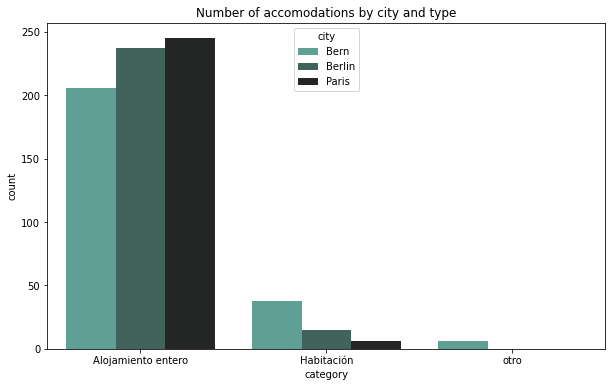

In [64]:
fig = plt.figure(figsize=(10, 6))

accom_count_per_city = sns.countplot(
    x="category", hue="city", data=airbnb_data, palette="dark:#5A9_r"
)

plt.title("Number of accomodations by city and type")
plt.show()

### Median of price grouped by country

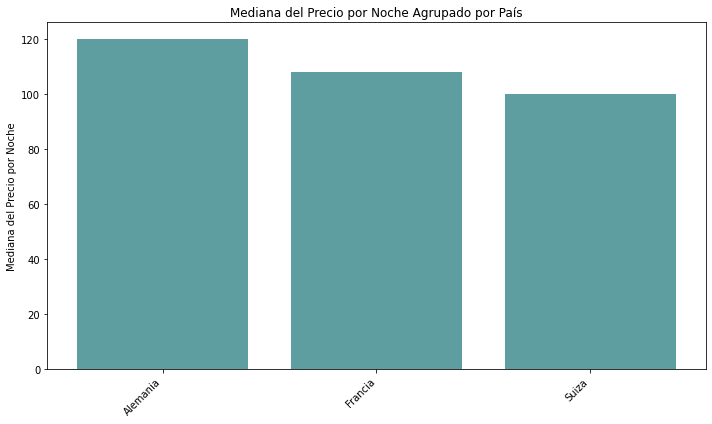

In [65]:
median_prices = airbnb_data.groupby("country")["price_per_night"].median().reset_index()

# Gráfico de barras
fig = plt.figure(figsize=(10, 6))
plt.bar(median_prices["country"], median_prices["price_per_night"], color="cadetblue")

# Etiquetas
plt.ylabel("Mediana del Precio por Noche")
plt.title("Mediana del Precio por Noche Agrupado por País")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()